In [1]:
import os, shutil
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split

In [28]:
# original data directories
CT = '../Data/CT/'
MRI = '../Data/MRI/'
PET = '../Data/PET/'

myPaths = [CT, MRI, PET]
myDict={CT:[], MRI:[], PET:[]}

for path in myPaths:
    myDict[path] = [f for f in listdir(path) if isfile(join(path, f))]
    #print(len(myDict[path]))
    #print(myDict[path])


print(list(myDict.keys()))

#split train test
CT_train, CT_test = train_test_split(myDict[myPaths[0]], train_size=0.8)
MRI_train, MRI_test = train_test_split(myDict[myPaths[1]], train_size=0.8)
PET_train, PET_test = train_test_split(myDict[myPaths[2]], train_size=0.8)

#split train validation
#CT_train, CT_validation = train_test_split(CT_train, train_size=0.75)
#MRI_train, MRI_validation = train_test_split(MRI_train, train_size=0.75)
#PET_train, PET_validation = train_test_split(PET_train, train_size=0.75)

#print(len(MRI_train))
#print(len(MRI_validation))
#print(len(MRI_test))


# unisco
train = CT_train + MRI_train + PET_train
#validation = CT_validation + MRI_validation + PET_validation
test_file_names = CT_test + MRI_test + PET_test
#label_test = len(CT_test)*['CT']

#print(label_test)
#print(CT_train)
#print(len(validation))
print(test_file_names)

['../Data/CT/', '../Data/MRI/', '../Data/PET/']
['CT190.png', 'CT245.png', 'CT321.png', 'CT36.png', 'CT113.png', 'CT213.png', 'CT80.png', 'CT259.png', 'CT109.png', 'CT30.png', 'CT277.png', 'CT96.png', 'CT208.png', 'CT62.png', 'CT306.png', 'CT339.png', 'CT108.png', 'CT237.png', 'CT241.png', 'CT260.png', 'CT234.png', 'CT11.png', 'CT73.png', 'CT139.png', 'CT209.png', 'CT310.png', 'CT118.png', 'CT269.png', 'CT249.png', 'CT127.png', 'CT81.png', 'CT71.png', 'CT15.png', 'CT123.png', 'CT120.png', 'CT16.png', 'CT290.png', 'CT182.png', 'CT43.png', 'CT59.png', 'CT196.png', 'CT166.png', 'CT111.png', 'CT344.png', 'CT298.png', 'CT156.png', 'CT317.png', 'CT207.png', 'CT275.png', 'CT336.png', 'CT35.png', 'CT164.png', 'CT184.png', 'CT61.png', 'CT211.png', 'CT185.png', 'CT55.png', 'CT322.png', 'CT315.png', 'CT328.png', 'CT244.png', 'CT82.png', 'CT206.png', 'CT319.png', 'CT142.png', 'CT232.png', 'CT26.png', 'CT19.png', 'CT95.png', 'CT153.png', 'CT219.png', 'MRI90.png', 'MRI268.png', 'MRI243.png', 'MRI31.

In [29]:
# creo cartella data

print('Creo la cartella per i dati qui:', os.getcwd())

directories = ['data/train', 
               #'data/validation', 
               'data/test']

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

scans = ['CT', 'MRI', 'PET']

for dest in directories:
    for source, scan in zip(myPaths, scans):
        files = eval(scan+'_test')
        #print(files)
        for f in files:
            shutil.copy(source+f, dest)

Creo la cartella per i dati qui: /Users/orobix/Documents/Thesis/Source/Code


Grandezza immagini: (180, 180)
TEST DATABASE: (214, 180, 180, 1)


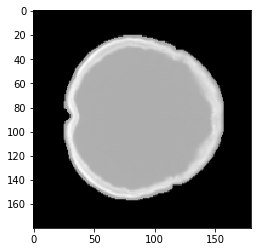

In [30]:
#creo l'array per passarlo poi al file come database

from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2


# lista per fare image reading
location_test_dir ='data/test/'
location_test_file_names = [location_test_dir + item for item in test_file_names]
#print(location_test_file_names)

#inizialize stack
x = io.imread(location_test_file_names[0])
x = cv2.resize(x, dsize=(180,180))
plt.imshow(x, cmap=plt.cm.gray)

#grandezza immagini
print('Grandezza immagini:', x.shape)

y=[]
#stack images
for img in location_test_file_names[1:]: #parti dalla seconda immagine
    y.append(str(img)[10:12])
    img = io.imread(img)
    img = cv2.resize(img, dsize=(180,180))
    x = np.dstack((x,img))

#reshape and normalise
#x = np.rollaxis(x,-1) #(182,218,N)->(N,182,218)
x = x.reshape(-1, 180, 180, 1).astype('float32')
x = x/255. 
print('TEST DATABASE:', x.shape)



In [31]:
#model CAE

from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model

input_shape=(180,180,1) 
filters=[32, 64, 128, 10]

model = Sequential()

if input_shape[0] % 8 == 0:
    pad3 = 'same'
else:
    pad3 = 'valid'

model.add(Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape))

model.add(Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))

model.add(Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3'))

model.add(Flatten())
model.add(Dense(units=filters[3], name='embedding'))
model.add(Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))

model.add(Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
model.add(Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))

model.add(Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))

model.add(Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))
model.summary()
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 90, 90, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 45, 45, 64)        51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 22, 22, 128)       73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 61952)             0         
_________________________________________________________________
embedding (Dense)            (None, 10)                619530    
_________________________________________________________________
dense_6 (Dense)              (None, 61952)             681472    
_________________________________________________________________
reshape_6 (Reshape)          (None, 22, 22, 128)       0         
__________

In [32]:
# compile the model and callbacks
optimizer = 'adam'
model.compile(optimizer=optimizer, loss='mse')

In [33]:
print(x.shape)

from time import time
t0 = time()
model.fit(x, x, batch_size=16, epochs=20)
print('Training time: ', time() - t0)

(214, 180, 180, 1)
Epoch 1/20
214/214 [==============================] - 9s 43ms/step - loss: 0.0803
Epoch 2/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0527
Epoch 3/20
214/214 [==============================] - 7s 34ms/step - loss: 0.0432
Epoch 4/20
214/214 [==============================] - 7s 32ms/step - loss: 0.0352
Epoch 5/20
214/214 [==============================] - 6s 30ms/step - loss: 0.0303
Epoch 6/20
214/214 [==============================] - 6s 30ms/step - loss: 0.0263
Epoch 7/20
214/214 [==============================] - 6s 29ms/step - loss: 0.0246
Epoch 8/20
214/214 [==============================] - 6s 30ms/step - loss: 0.0235
Epoch 9/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0230
Epoch 10/20
214/214 [==============================] - 6s 29ms/step - loss: 0.0225
Epoch 11/20
214/214 [==============================] - 6s 29ms/step - loss: 0.0221
Epoch 12/20
214/214 [==============================] - 6s 29ms/step - loss: 0

In [20]:
feature_model = Model(inputs=model.input, outputs=model.get_layer(name='embedding').output)
features = feature_model.predict(x)
print('feature shape=', features.shape)

feature shape= (214, 10)


In [22]:
# use features for clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)

In [23]:
features = np.reshape(features, newshape=(features.shape[0], -1))
pred = km.fit_predict(features)

In [24]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
#next: risolvi problema come determinare la accuracy

In [26]:
print('acc=', acc(y, pred), 'nmi=', nmi(y, pred), 'ari=', ari(y, pred))

AttributeError: 'list' object has no attribute 'astype'